# YouTube热门视频数据分析

该数据集来自Kaggle（ https://www.kaggle.com/datasnaek/youtube-new ）  
包含有关YouTube每日热门视频的数月（且在不断增加）的数据，现选择美国地区的数据子集进行分析。  
数据维度包括视频标题，频道标题，发布时间，标签，观看次数，喜欢和不喜欢，描述以及评论数。  

### Part 1 数据准备阶段

#### 1. 导入库

In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import  matplotlib as mpl
from matplotlib import cm
import os
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

mpl.rcParams['figure.figsize'] = (10,10)

#### 2. 读取数据

In [2]:
file_name = 'C:/Users/zhuangshuting/Desktop/Youtube项目数据/USvideos.csv'
my_df = pd.read_csv(file_name, index_col='video_id')

#### 3. 数据总览

In [3]:
print(my_df.shape)
print(my_df.nunique())

(40949, 15)
trending_date               205
title                      6455
channel_title              2207
category_id                  16
publish_time               6269
tags                       6055
views                     40478
likes                     29850
dislikes                   8516
comment_count             13773
thumbnail_link             6352
comments_disabled             2
ratings_disabled              2
video_error_or_removed        2
description                6901
dtype: int64


#### 4. 预览缺失值和数据类型

In [4]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40949 entries, 2kyS6SvSYSE to ooyjaVdt-jA
Data columns (total 15 columns):
trending_date             40949 non-null object
title                     40949 non-null object
channel_title             40949 non-null object
category_id               40949 non-null int64
publish_time              40949 non-null object
tags                      40949 non-null object
views                     40949 non-null int64
likes                     40949 non-null int64
dislikes                  40949 non-null int64
comment_count             40949 non-null int64
thumbnail_link            40949 non-null object
comments_disabled         40949 non-null bool
ratings_disabled          40949 non-null bool
video_error_or_removed    40949 non-null bool
description               40379 non-null object
dtypes: bool(3), int64(5), object(7)
memory usage: 4.2+ MB


#### 5. 预览前5行

In [5]:
my_df.head()

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
video_id,,,,,,,,,,,,,,,
2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


#### 6. 数据清洗——修正日期数据格式

通过观察发现，将原始数据集中的发布时间publish_time和推荐时间trending_time的时间这两列时间数据转化为标准格式

a) 修正推荐日期trending_time的格式

In [6]:
my_df['trending_date'] = pd.to_datetime(my_df['trending_date'], format = '%y.%d.%m')
my_df['trending_date'].head

<bound method NDFrame.head of video_id
2kyS6SvSYSE   2017-11-14
1ZAPwfrtAFY   2017-11-14
5qpjK5DgCt4   2017-11-14
puqaWrEC7tY   2017-11-14
d380meD0W0M   2017-11-14
gHZ1Qz0KiKM   2017-11-14
39idVpFF7NQ   2017-11-14
nc99ccSXST0   2017-11-14
jr9QtXwC9vc   2017-11-14
TUmyygCMMGA   2017-11-14
9wRQljFNDW8   2017-11-14
VifQlJit6A0   2017-11-14
5E4ZBSInqUU   2017-11-14
GgVmn66oK_A   2017-11-14
TaTleo4cOs8   2017-11-14
kgaO45SyaO4   2017-11-14
ZAQs-ctOqXQ   2017-11-14
YVfyYrEmzgM   2017-11-14
eNSN6qet1kE   2017-11-14
B5HORANmzHw   2017-11-14
vU14JY3x81A   2017-11-14
6VhU_T463sU   2017-11-14
_-aDHxoblr4   2017-11-14
JBZTZZAcFTw   2017-11-14
lZ68j2J_GOM   2017-11-14
dRpNZV18N_g   2017-11-14
fcVjitaM3LY   2017-11-14
qeWvgZLz9yU   2017-11-14
iIxy3JN3-jc   2017-11-14
n30k5CwLhS4   2017-11-14
                 ...    
vDyYMcjf500   2018-06-14
3Q2j5ApzSqs   2018-06-14
GfxNGjfSKRY   2018-06-14
amtC28yfYCM   2018-06-14
9NC2saE5MbQ   2018-06-14
XdNOI-q70q4   2018-06-14
QgOXIEhHU1Y   2018-06-14
SQsPvrev_bQ

b) 修正发布日期publish_time的格式，并新增星期列：publish_day、trending_day、pubulish_hour

In [7]:
my_df['publishing_day'] = my_df['publish_time'].apply(lambda x: pd.datetime.strptime(x[:10], "%Y-%m-%d").date().strftime('%a'))
my_df['trending_day'] = my_df['trending_date'].dt.weekday
my_df['publishing_hour'] = my_df['publish_time'].apply(lambda x: x[11:13])
my_df[['publishing_day', 'trending_day', 'publishing_hour']].head()

,publishing_day,trending_day,publishing_hour
video_id,,,
2kyS6SvSYSE,Mon,1,17
1ZAPwfrtAFY,Mon,1,07
5qpjK5DgCt4,Sun,1,19
puqaWrEC7tY,Mon,1,11
d380meD0W0M,Sun,1,18


#### 7. 数据清洗——修改数据类型

将观看量、点赞数、不喜欢数、评论数等关键指标由float格式转化为int格式；将Catogory_id由int转化为字符串string格式

In [8]:
type_int_list = ['views', 'likes', 'dislikes', 'comment_count']
for column in type_int_list:
    my_df[column] = my_df[column].astype(int)

type_str_list = ['category_id']
for column in type_str_list:
    my_df[column] = my_df[column].astype(str)

#### 8. 数据清洗——导入相关数据成为新增列

通过导入另一个文件US_category_id.json向数据中添加“视频类型”列  
a) 匹配id和category

In [9]:
id_to_category = {}

with open ('C:/Users/zhuangshuting/Desktop/Youtube项目数据/US_category_id.json', 'r') as f:
    data = json.load(f)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']

id_to_category

{'1': 'Film & Animation',
 '2': 'Autos & Vehicles',
 '10': 'Music',
 '15': 'Pets & Animals',
 '17': 'Sports',
 '18': 'Short Movies',
 '19': 'Travel & Events',
 '20': 'Gaming',
 '21': 'Videoblogging',
 '22': 'People & Blogs',
 '23': 'Comedy',
 '24': 'Entertainment',
 '25': 'News & Politics',
 '26': 'Howto & Style',
 '27': 'Education',
 '28': 'Science & Technology',
 '29': 'Nonprofits & Activism',
 '30': 'Movies',
 '31': 'Anime/Animation',
 '32': 'Action/Adventure',
 '33': 'Classics',
 '34': 'Comedy',
 '35': 'Documentary',
 '36': 'Drama',
 '37': 'Family',
 '38': 'Foreign',
 '39': 'Horror',
 '40': 'Sci-Fi/Fantasy',
 '41': 'Thriller',
 '42': 'Shorts',
 '43': 'Shows',
 '44': 'Trailers'}

b) 插入category列

In [10]:
my_df.insert(4, 'category', my_df['category_id'].map(id_to_category))
my_df[['category_id', 'category']].head()

,category_id,category
video_id,,
2kyS6SvSYSE,22,People & Blogs
1ZAPwfrtAFY,24,Entertainment
5qpjK5DgCt4,23,Comedy
puqaWrEC7tY,24,Entertainment
d380meD0W0M,24,Entertainment


#### 9. 数据清洗——去除重复数据

通过观察可以发现，原始数据集4万余条数据中，某一条推荐视频ID一般会在推荐榜单停留多天，因此我们针对video_id做去重处理，只留下每一条推荐视频最后一天的数据。

In [11]:
print(my_df.shape)
my_df = my_df[~my_df.index.duplicated(keep='last')]
print(my_df.shape)
my_df.index.duplicated().any()

(40949, 19)
(6351, 19)


False

### Part 2 数据分析阶段

#### 1. 基础指标——描述性统计

作为全球最大最强的UGC互联网视频网站，用户参与度是Youtube关心的核心指标，而观看量、点赞、不喜欢和评论量是反应用户参与度的重要指标，因此对这几个核心指标进行描述性统计，可以看出：

a）推荐视频四项指标的数量级分别为：观看量>喜欢>评论>不喜欢

b）推荐视频的指标均值为观看量200万，点赞量5.5万，评论量3.4千，不喜欢3.2千

c）推荐视频的四项指标均接近正态分布

In [12]:
my_df[['views','likes','dislikes','comment_count']].describe()

,views,likes,dislikes,comment_count
count,6.351000e+03,6.351000e+03,6.351000e+03,6.351000e+03
mean,1.962117e+06,5.557505e+04,3.067153e+03,6.450745e+03
std,7.060057e+06,1.938307e+05,3.198849e+04,3.382370e+04
min,5.590000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.591565e+05,2.772500e+03,1.270000e+02,3.720000e+02
50%,5.181070e+05,1.190600e+04,4.440000e+02,1.266000e+03
75%,1.473582e+06,3.842850e+04,1.507000e+03,4.061500e+03
max,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


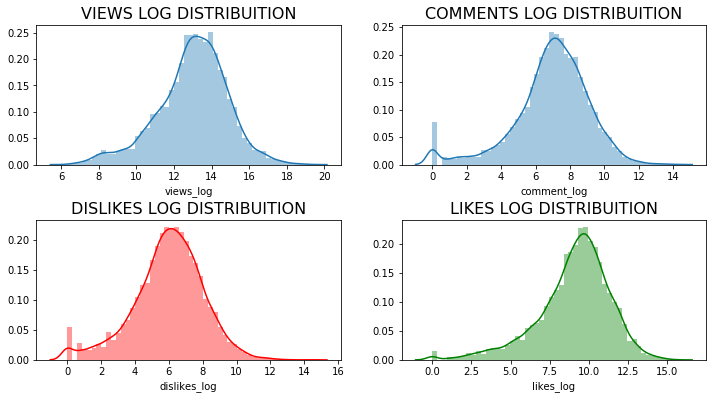

In [13]:
# numpy.log()是一个数学函数, 用于计算x(x属于所有输入数组元素)的自然对数
my_df['likes_log'] = np.log(my_df['likes'] + 1)
my_df['views_log'] = np.log(my_df['views'] + 1)
my_df['dislikes_log'] = np.log(my_df['dislikes'] + 1)
my_df['comment_log'] = np.log(my_df['comment_count'] + 1)

plt.figure(figsize=(12,6))

plt.subplot(221)
g1 = sns.distplot(my_df['views_log'])
g1.set_title('VIEWS LOG DISTRIBUITION', fontsize=16)

plt.subplot(224)
g2 = sns.distplot(my_df['likes_log'], color='green')
g2.set_title('LIKES LOG DISTRIBUITION', fontsize=16)

plt.subplot(223)
g3 = sns.distplot(my_df['dislikes_log'], color='red')
g3.set_title('DISLIKES LOG DISTRIBUITION', fontsize=16)

plt.subplot(222)
g4 = sns.distplot(my_df['comment_log'])
g4.set_title('COMMENTS LOG DISTRIBUITION', fontsize=16)

plt.subplots_adjust(wspace=0.2, hspace=0.4, top=0.9)

plt.show()

#### 2. 转化率指标分析

分析转化率指标的分布情况

a）推荐视频四项指标的转化率均值分别为 ：①观看-点赞 3%；②观看-评论 0.4%；③观看-不喜欢 0.16%

b）“点赞”的分布相对分散，“评论”和“不喜欢”的分布都非常集中，证明观众对于热门视频中喜爱程度因人而异，点赞趋向平均且分散，但对于想要发表评论和不喜欢的意见的视频则相对集中

观看-点赞转化率平均值: 2.9655738771713365
观看-不喜欢转化率平均值: 0.15935640471725993
观看-评论转化率平均值: 0.4051785150755074


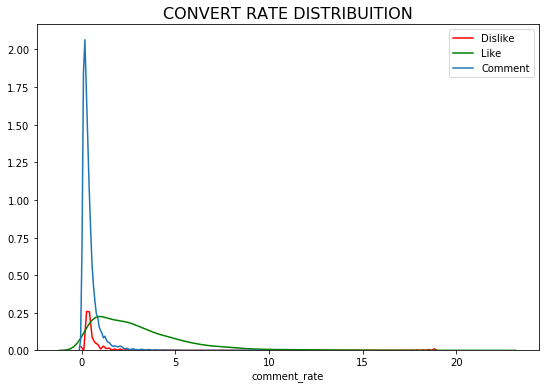

In [14]:
my_df['like_rate'] = my_df['likes'] / my_df['views'] * 100
my_df['dislike_rate'] = my_df['dislikes'] / my_df['views'] * 100
my_df['comment_rate'] = my_df['comment_count'] / my_df['views'] * 100

print('观看-点赞转化率平均值:', my_df['like_rate'].mean())
print('观看-不喜欢转化率平均值:', my_df['dislike_rate'].mean())
print('观看-评论转化率平均值:', my_df['comment_rate'].mean())

plt.figure(figsize=(9,6))

g1 = sns.distplot(my_df['dislike_rate'], color='red', hist=False, label='Dislike')
g1 = sns.distplot(my_df['like_rate'], color='green', hist=False, label='Like')
g1 = sns.distplot(my_df['comment_rate'], hist=False, label='Comment')
g1.set_title('CONVERT RATE DISTRIBUITION', fontsize=16)
plt.legend()
plt.show()


#### 3. 按品类聚合核心指标

按品类聚合后推荐视频观看量、点赞量和不喜欢量的分布情况

a）热门视频数最高的三类视频是：娱乐类、音乐类、教学和风格类  
b）游戏类、音乐类和喜剧类视频是观看量和点赞量中表现最好的。但是，娱乐类虽然热门视频数量最多，在观看量和点赞量上的表现并不是最突出的  
c）新闻政治类和非盈利类视频在观看、点赞和评论等各项指标中都显著低于其他类别。但不同的是，非盈利类的热门视频数量与关键指标一样很低，但新闻政治类的数量则比较靠前，排在第5位

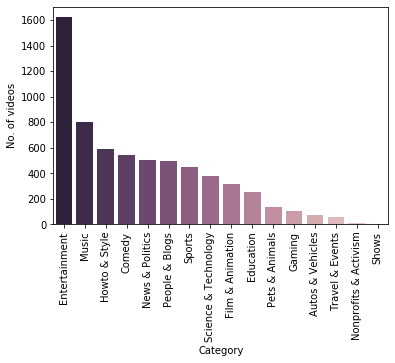

In [15]:
cdf = my_df['category'].value_counts().to_frame().reset_index()
cdf.rename(columns={'index': 'category', 'category': 'No_of_videos'}, inplace=True)
fig, ax = plt.subplots()
_ = sns.barplot(x='category', y='No_of_videos', data=cdf, palette=sns.cubehelix_palette(n_colors=16, reverse=True), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel='Category', ylabel='No. of videos')


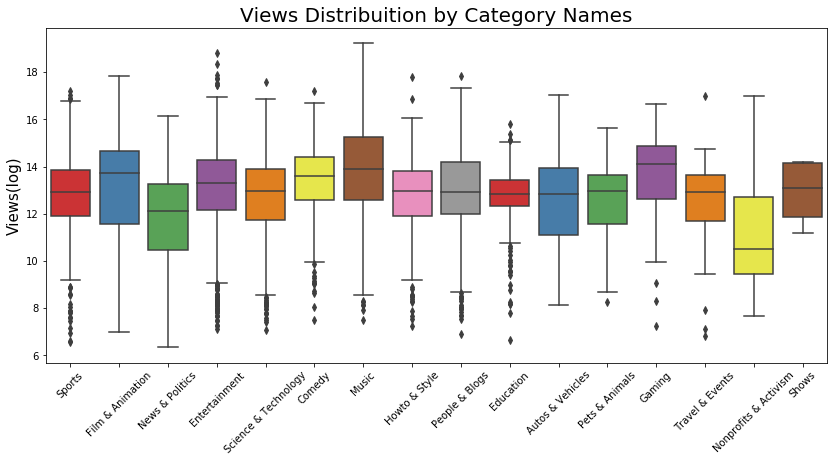

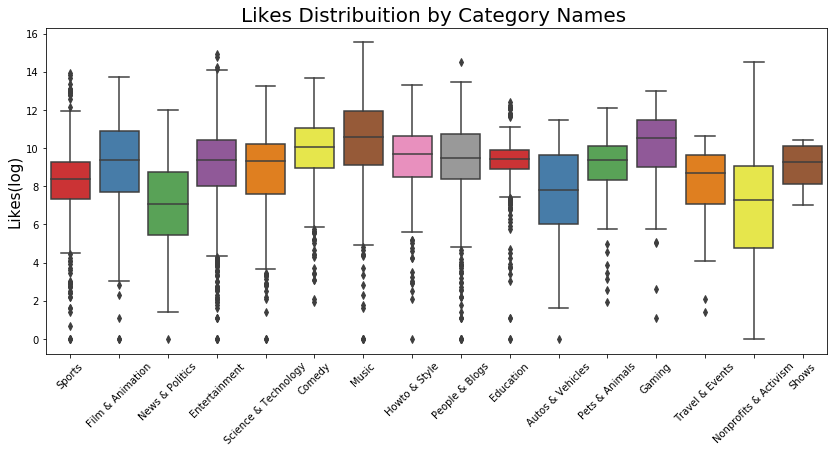

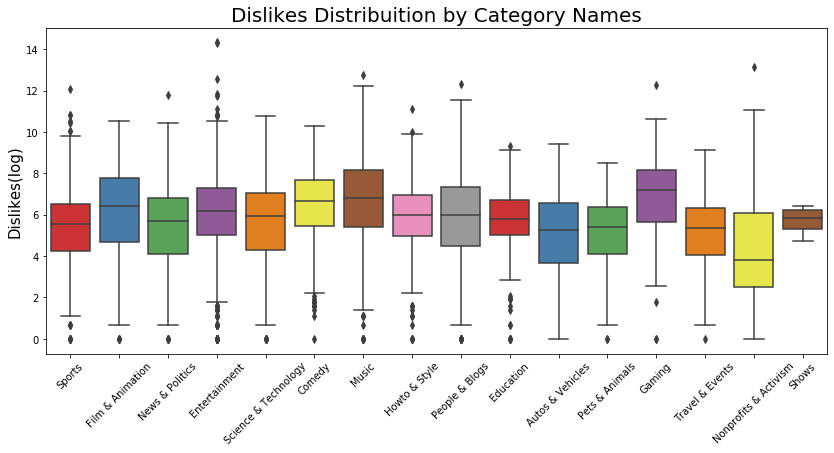

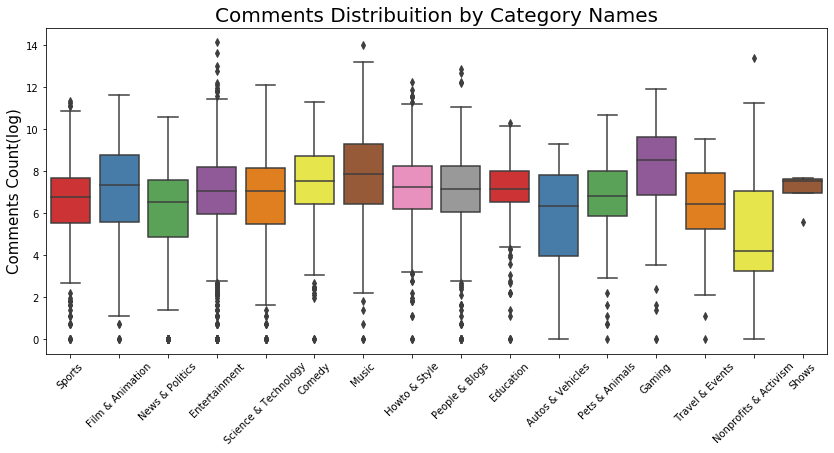

In [16]:
# 按品类聚合后推荐视频的观看量、点赞量、不喜欢量、评论量分布情况
plt.figure(figsize = (14,6))

g1 = sns.boxplot(x='category', y='views_log', data=my_df, palette='Set1')
g1.set_xticklabels(g1.get_xticklabels(), rotation=45)
g1.set_title('Views Distribuition by Category Names', fontsize=20)
g1.set_xlabel('', fontsize=15)
g1.set_ylabel('Views(log)', fontsize=15)
plt.subplots_adjust(hspace=0.9, top=0.9)
plt.show()

plt.figure(figsize = (14,6))

g2 = sns.boxplot(x='category', y='likes_log', data=my_df, palette="Set1")
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)
g2.set_title("Likes Distribuition by Category Names ", fontsize=20)
g2.set_xlabel("", fontsize=15)
g2.set_ylabel("Likes(log)", fontsize=15)
plt.show()

plt.figure(figsize = (14,6))

g3 = sns.boxplot(x='category', y='dislikes_log', data=my_df, palette="Set1")
g3.set_xticklabels(g3.get_xticklabels(),rotation=45)
g3.set_title("Dislikes Distribuition by Category Names", fontsize=20)
g3.set_xlabel("", fontsize=15)
g3.set_ylabel("Dislikes(log)", fontsize=15)
plt.show()

plt.figure(figsize = (14,6))

g4 = sns.boxplot(x='category', y='comment_log', data=my_df, palette="Set1")
g4.set_xticklabels(g4.get_xticklabels(),rotation=45)
g4.set_title("Comments Distribuition by Category Names", fontsize=20)
g4.set_xlabel("", fontsize=15)
g4.set_ylabel("Comments Count(log)", fontsize=15)

plt.show()


#### 4. 按频道聚合核心指标

按频道聚合后推荐视频观看量、点赞量和不喜欢量的分布情况

热门视频数最高的TOP 10频道是：ESPN、艾伦秀、肥伦秀、鸡毛秀、奈飞、史蒂文库布特秀、NBA、CNN、Vox、詹姆斯戈登秀，可以看出产出热门视频数最多的频道是脱口秀栏目的频道，占据了半壁江山，其余被体育频道和新闻频道瓜分

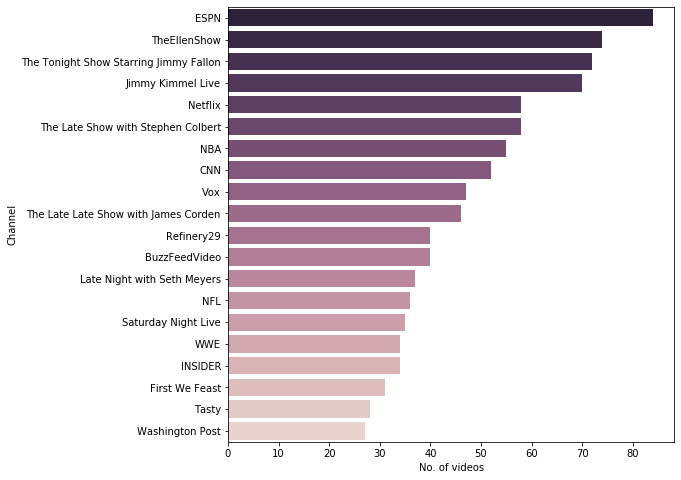

In [17]:
cdf = my_df.groupby('channel_title').size().reset_index(name='video_count').sort_values('video_count', ascending=False).head(20)
fig, ax = plt.subplots(figsize=(8,8))
_ = sns.barplot(x='video_count', y='channel_title', data=cdf, palette=sns.cubehelix_palette(n_colors=20, reverse=True), ax=ax)
_ = ax.set(xlabel='No. of videos', ylabel='Channel')


#### 5. 核心指标之间的相关性

观看量、点赞量、不喜欢量和评论量之间存在着强相关，其中观看和点赞量、观看和不喜欢量的相关性最强

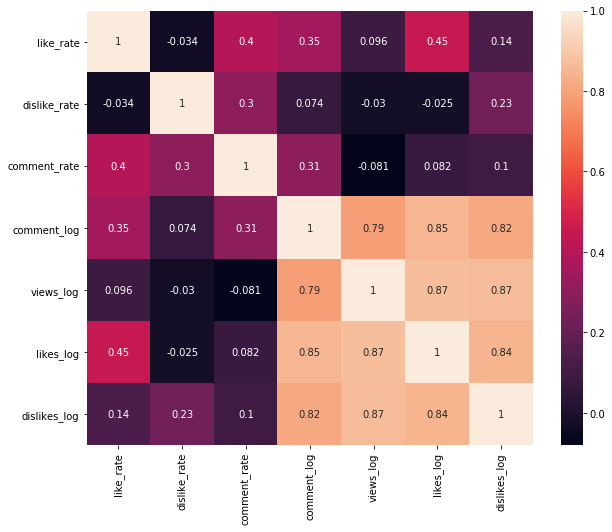

In [18]:
# 核心数据指标之间的相关性
plt.figure(figsize = (10,8))
sns.heatmap(my_df[['like_rate', 'dislike_rate', 'comment_rate', 'comment_log', 'views_log', 'likes_log', 'dislikes_log', 'category']].corr(), annot=True)
plt.show()


#### 6. 时间指标分析——发布星期和发布时间

a) 出人意料地，数据显示，周日和周六热门视频推荐数量明显少于一周其他日期发布的热门视频推荐数量。可能正因为如此，热门视频的创作者们也通常将视频的发布时间选在周一至周五。

b) 数据显示，从2PM到7PM之间的时段（在4PM和5PM之间达到峰值）的热门视频的发布数量最多。上午12点至下午1点之间发布的热门视频数量最少。可见创作者们更趋向于在下午和傍晚发布视频。

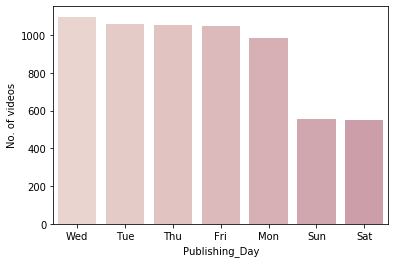

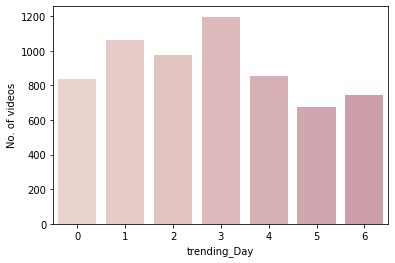

In [19]:
# 发布星期分析
cdf = my_df['publishing_day'].value_counts().to_frame().reset_index().rename(columns={'index': 'publishing_day', 'publishing_day': 'No_of_videos'})
fig, ax = plt.subplots()
_ = sns.barplot(x='publishing_day', y='No_of_videos', data=cdf, palette=sns.cubehelix_palette(n_colors=24), ax=ax)
_ = ax.set(xlabel='Publishing_Day', ylabel='No. of videos')

cdf = my_df['trending_day'].value_counts().to_frame().reset_index().rename(columns={'index': 'trending_day', 'trending_day': 'No_of_videos'})
fig, ax = plt.subplots()
_ = sns.barplot(x='trending_day', y='No_of_videos', data=cdf, palette=sns.cubehelix_palette(n_colors=24), ax=ax)
_ = ax.set(xlabel='trending_Day', ylabel='No. of videos')


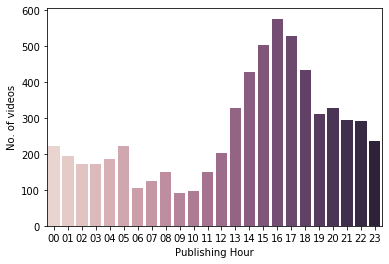

In [20]:
# 发布精准时间分析
cdf = my_df['publishing_hour'].value_counts().to_frame().reset_index().rename(columns={'index':'publishing_hour', 'publishing_hour':'No_of_videos'})
fig, ax = plt.subplots()
_ = sns.barplot(x='publishing_hour', y='No_of_videos', data=cdf, palette=sns.cubehelix_palette(n_colors=24), ax=ax)
_ = ax.set(xlabel='Publishing Hour', ylabel='No. of videos')


#### 7. 文字指标分析——标题长度

a) 标题长度分布类似于正态分布，其中大多数视频的标题长度大约在30到60个字符之间  
b) 标题长度和观看量无显著相关关系，但观看次数超过1亿的视频的标题长度大约在33到55个字符之间

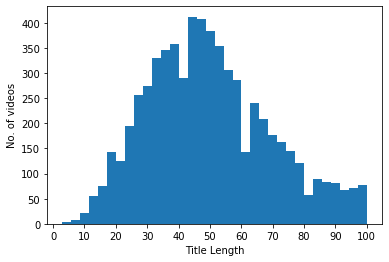

In [21]:
# 标题文字长度分析
my_df['title_length'] = my_df['title'].apply(lambda x: len(x))
fig, ax = plt.subplots()
_ = sns.distplot(my_df['title_length'], kde=False, rug=False, hist_kws={'alpha':1}, ax=ax)
_ = ax.set(xlabel='Title Length', ylabel='No. of videos', xticks=range(0,110,10))


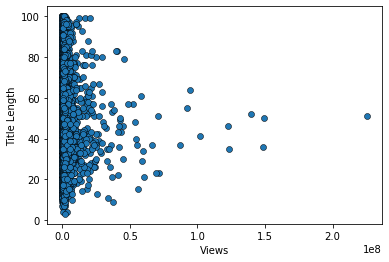

In [22]:
# 标题长度与观看量的关系
fig, ax = plt.subplots()
_ = ax.scatter(x=my_df['views'], y=my_df['title_length'], edgecolors='#000000', linewidths=0.5)
_ = ax.set(xlabel='Views', ylabel='Title Length')

#### 8. 文字指标分析——标题词频

a) 忽略“the”和“of”之类的无意义单词，我们可以看到“-”和“|” 符号在热门视频标题中出现的次数很多，可知热门视频的作者比较注意标题的格式清晰   
b) 词云中显眼的单词即为热门标题中最常出现的单词，一定程度上可以从中获取热门视频题材的灵感，视频标签和视频简介同理

[('|', 1788), ('-', 1554), ('The', 927), ('the', 616), ('to', 405), ('a', 404), ('of', 402), ('in', 367), ('and', 317), ('&', 305), ('A', 305), ('with', 288), ('on', 286), ('2018', 275), ('I', 271), ('Trailer', 261), ('How', 249), ('Official', 216), ('To', 203), ('Video)', 197), ('for', 178), ('(Official', 168), ('You', 165), ('With', 147), ('My', 140)]


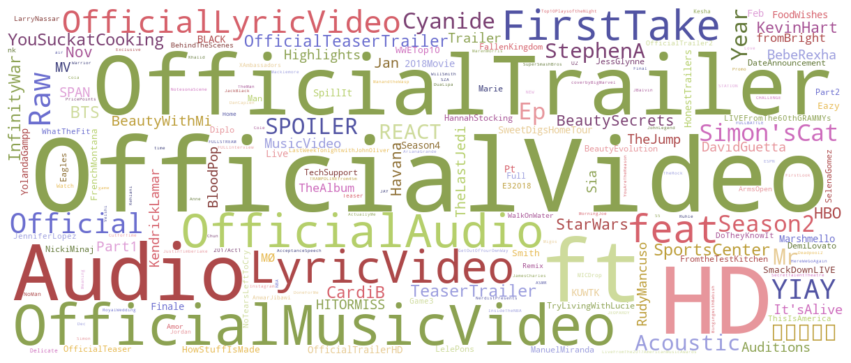

In [23]:
# 标题中最常见的词的分析
title_words = list(my_df['title'].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
words = Counter(title_words).most_common(25)
print(words)

wc = WordCloud(width=1200, height=500, collocations=False, background_color='white', colormap='tab20b').generate(''.join(title_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis('off')


### Part3 分析结论呈现

1. 通过观察可以发现，原始数据集4万余条数据中，某一条推荐视频ID一般会在推荐榜单停留多天，因此我们针对video_id做去重处理，只留下每一条推荐视频最后一天的数据    
2. **关键指标的描述性统计**  
作为全球最大最强的UGC互联网视频网站，用户参与度是Youtube关心的核心指标，而观看量、点赞、不喜欢和评论量是反应用户参与度的重要指标，因此对这几个核心指标进行描述性统计，可以看出：  
a）推荐视频四项指标的数量级分别为：观看量>喜欢>评论>不喜欢  
b）推荐视频的指标均值为观看量200万，点赞量5.5万，评论量3.4千，不喜欢3.2千  
c）推荐视频的四项指标均接近正态分布  
3. **核心指标转化率分析**  
分析转化率指标的分布情况  
a）推荐视频四项指标的转化率均值分别为 ：①观看-点赞 3%；②观看-评论 0.4%；③观看-不喜欢 0.16%  
b）“点赞”的分布相对分散，“评论”和“不喜欢”的分布都非常集中，证明观众对于热门视频中喜爱程度因人而异，点赞趋向平均且分散，但对于想要发表评论和不喜欢的意见的视频则相对集中  
4. **按品类聚合核心指标**  
按品类聚合后推荐视频观看量、点赞量和不喜欢量的分布情况  
a）热门视频数最高的三类视频是：娱乐类、音乐类、教学和风格类  
b）游戏类、音乐类和喜剧类视频是观看量和点赞量中表现最好的。但是，娱乐类虽然热门视频数量最多，在观看量和点赞量上的表现并不是最突出的  
c）新闻政治类和非盈利类视频在观看、点赞和评论等各项指标中都显著低于其他类别。但不同的是，非盈利类的热门视频数量与关键指标一样很低，但新闻政治类的数量则比较靠前，排在第5位  
5. **按频道聚合核心指标**  
按频道聚合后推荐视频观看量、点赞量和不喜欢量的分布情况  
热门视频数最高的TOP 10频道是：ESPN、艾伦秀、肥伦秀、鸡毛秀、奈飞、史蒂文库布特秀、NBA、CNN、Vox、詹姆斯戈登秀，可以看出产出热门视频数最多的频道是脱口秀栏目的频道，占据了半壁江山，其余被体育频道和新闻频道瓜分  
6. **核心指标之间的相关性**  
观看量、点赞量、不喜欢量和评论量之间存在着强相关，其中观看和点赞量、观看和不喜欢量的相关性最强  
7. **时间维度分析——发布星期和发布时间**  
a）出人意料地，数据显示，周日和周六热门视频推荐数量明显少于一周其他日期发布的热门视频推荐数量。可能正因为如此，热门视频的创作者们也将热门视频的发布时间更多的选在周一至周五  
b）数据显示，从2PM到7PM之间的时段（在4PM和5PM之间达到峰值）的热门视频的发布数量最多。 上午12点至下午1点之间的时间段内发布的热门视频数量最少。可见创作者们更趋向于在下午和傍晚发布视频  
8. **文字分析——标题长度**  
a) 标题长度分布类似于正态分布，其中大多数视频的标题长度大约在30到60个字符之间  
b) 标题长度和观看量无显著相关关系，但观看次数超过1亿的视频的标题长度大约在33到55个字符之间  
9. **文字分析——标题文本**  
a) 忽略“the”和“of”之类的无意义单词，我们可以看到“-”和“|” 符号在热门视频标题中出现的次数很多，可知热门视频的作者比较注意标题的格式清晰  
b) 词云中显眼的单词即为热门标题中最常出现的单词，一定程度上可以从中获取热门视频题材的灵感，视频标签和视频简介同理  